# Nodule Segmentation in Lung Ct-scans

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration" data-toc-modified-id="Configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#LIDC-Dataset" data-toc-modified-id="LIDC-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LIDC Dataset</a></span><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Load-Dataset" data-toc-modified-id="Load-Dataset-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load Dataset</a></span></li><li><span><a href="#Split-scans-to-train,-validate,-and-test" data-toc-modified-id="Split-scans-to-train,-validate,-and-test-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Split scans to train, validate, and test</a></span></li><li><span><a href="#Filter-annotation-according-to-nodule-diameter" data-toc-modified-id="Filter-annotation-according-to-nodule-diameter-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Filter annotation according to nodule diameter</a></span></li><li><span><a href="#Plot-distribution-of-nodule-diameter" data-toc-modified-id="Plot-distribution-of-nodule-diameter-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Plot distribution of nodule diameter</a></span></li><li><span><a href="#Save-train,-validate,-and-test-scan-indices-in-a-file" data-toc-modified-id="Save-train,-validate,-and-test-scan-indices-in-a-file-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Save train, validate, and test scan indices in a file</a></span></li></ul></li><li><span><a href="#Nodule-Dataset" data-toc-modified-id="Nodule-Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Nodule Dataset</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Generate-Negative-Examples" data-toc-modified-id="Generate-Negative-Examples-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Generate Negative Examples</a></span></li><li><span><a href="#Read-Negative-Examples" data-toc-modified-id="Read-Negative-Examples-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>Read Negative Examples</a></span></li><li><span><a href="#Generate-Positive-Examples" data-toc-modified-id="Generate-Positive-Examples-3.0.4"><span class="toc-item-num">3.0.4&nbsp;&nbsp;</span>Generate Positive Examples</a></span></li><li><span><a href="#Read-Positive-Examples" data-toc-modified-id="Read-Positive-Examples-3.0.5"><span class="toc-item-num">3.0.5&nbsp;&nbsp;</span>Read Positive Examples</a></span></li><li><span><a href="#Combine-both-into-a-distribution-of-n:m-(pos:neg)" data-toc-modified-id="Combine-both-into-a-distribution-of-n:m-(pos:neg)-3.0.6"><span class="toc-item-num">3.0.6&nbsp;&nbsp;</span>Combine both into a distribution of n:m (pos:neg)</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-3.0.7"><span class="toc-item-num">3.0.7&nbsp;&nbsp;</span>Data Augmentation</a></span></li><li><span><a href="#Convert-into-rec-file" data-toc-modified-id="Convert-into-rec-file-3.0.8"><span class="toc-item-num">3.0.8&nbsp;&nbsp;</span>Convert into rec file</a></span></li><li><span><a href="#Repeat-for-validate" data-toc-modified-id="Repeat-for-validate-3.0.9"><span class="toc-item-num">3.0.9&nbsp;&nbsp;</span>Repeat for validate</a></span></li><li><span><a href="#Repeat-for-test" data-toc-modified-id="Repeat-for-test-3.0.10"><span class="toc-item-num">3.0.10&nbsp;&nbsp;</span>Repeat for test</a></span></li></ul></li></ul></li></ul></div>

## Configuration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib nbagg

In [2]:
%matplotlib inline

In [11]:
import sys
sys.path.insert(0,"./src")

In [12]:
import pylidc as pl #pip install -Iv scikit-image==0.13
from random import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
import random
import os
from imports import *

## LIDC Dataset

In [4]:
#!rm -r {root_path}

In [13]:
use_all_data = True

dataset_path = '/media/mas/Untitled/LIDC/DOI/'

root_path = '/home/mas/x110/Datasets/Dataset5/'
tmp_path = root_path + "tmp/"
processed_path = root_path +"processed/" 

In [6]:
!mkdir {root_path}
!mkdir {tmp_path}
!mkdir {tmp_path+"train/"}
!mkdir {tmp_path+"valid/"}
!mkdir {tmp_path+"test/"}
!mkdir {tmp_path+"train/pos/"}
!mkdir {tmp_path+"train/neg/"}
!mkdir {tmp_path+"valid/pos/"}
!mkdir {tmp_path+"valid/neg/"}
!mkdir {tmp_path+"test/pos/"}
!mkdir {tmp_path+"test/neg/"}
!mkdir {processed_path}

In [7]:
train_test_split_path =   tmp_path + "scan_id_split.idx"#save the scan ids that will be considered

dftrain_path =  tmp_path + "dftrain.csv"
dfvalid_path =  tmp_path + "dfvalid.csv"
dftest_path  =  tmp_path + "dftest.csv"

ds_train = 'train'
ds_test = 'test'
ds_valid = 'valid'

### Description

"The Lung Image Database Consortium image collection (LIDC-IDRI) consists of diagnostic and lung cancer screening thoracic computed tomography (CT) scans with marked-up annotated lesions. It is a web-accessible international resource for development, training, and evaluation of computer-assisted diagnostic (CAD) methods for lung cancer detection and diagnosis. Initiated by the National Cancer Institute (NCI), further advanced by the Foundation for the National Institutes of Health (FNIH), and accompanied by the Food and Drug Administration (FDA) through active participation, this public-private partnership demonstrates the success of a consortium founded on a consensus-based process.

Seven academic centers and eight medical imaging companies collaborated to create this data set which contains **1018 cases**.  Each subject includes images from a clinical thoracic CT scan and an associated XML file that records the results of a two-phase image annotation process performed by four experienced thoracic radiologists. In the initial blinded-read phase, each radiologist independently reviewed each CT scan and marked lesions belonging to one of three categories ("nodule > or =3 mm," "nodule <3 mm," and "non-nodule > or =3 mm"). In the subsequent unblinded-read phase, each radiologist independently reviewed their own marks along with the anonymized marks of the three other radiologists to render a final opinion. The goal of this process was to identify as completely as possible all lung nodules in each CT scan without requiring forced consensus." [[1]](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI)

 [Download dataset here](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI)

In [8]:
#uncomment to download the data
#!apt-get install icedtea-netx
#!javaws TCIA_LIDC-IDRI_06-22-2015.jnlp

### Load Dataset

In [9]:
files = !ls {dataset_path}
files = [f for f in files if not f.endswith(".zip")]

In [14]:
if not use_all_data:
    files = ['LIDC-IDRI-'+str(i+1).zfill(4) for i in range(12)]
#files

In [15]:
qu = pl.query(pl.Scan)

In [16]:
scans=qu.all() #all scans in the original LIDC dataset
scans[0:5]

[Scan(id=1,patient_id=LIDC-IDRI-0078),
 Scan(id=2,patient_id=LIDC-IDRI-0069),
 Scan(id=3,patient_id=LIDC-IDRI-0079),
 Scan(id=4,patient_id=LIDC-IDRI-0101),
 Scan(id=5,patient_id=LIDC-IDRI-0110)]

In [17]:
ind = [i for i,s in enumerate(scans) if s.patient_id in files]
#ind

In [18]:
mini_scans=[scans[i] for i in ind];  #mini_scans

In [19]:
#scan=mini_scans[0]
#scan.annotations
#scan.visualize()

In [20]:
#check all scans are ok to read
scans_ok=[]
scans_error=[]

for q in mini_scans:
    try:
        q.get_path_to_dicom_files()
        scans_ok.append(q)
    except:
        scans_error.append(q)

print(len(scans_ok),len(scans_error),len(mini_scans))

1012 1 1013


### Split scans to train, validate, and test

split scans into 60% for training, 20% for validation, and 20% for testing

In [21]:
#shuffle data, then split to train, valid, test
random.seed(313)
random.shuffle(scans_ok)
L=len(scans_ok)
j=np.int(.6*L)
jj=np.int(.2*L)
scans_train=scans_ok[0:j]
scans_valid=scans_ok[j:j+jj]
scans_test=scans_ok[j+jj:]
print(len(scans_train),len(scans_valid),len(scans_test))

607 202 203


In [22]:
#scans_train,scans_valid,scans_test

### Filter annotation according to nodule diameter

We will consider only annonations of diameter < 30mm  and greater than 6mm 

In [23]:
scans0=scans_train
filename = dftrain_path

#consider only annonations of diameter < 30mm  and greater than 6mm 

if True:

    l=[q.annotations for q in scans0]
    anns = [item for sublist in l for item in sublist]

    columns=['ann_id','scan_id','nodule_diameter']

    df=[]
    for scan in scans0:
        for a in scan.annotations:
            row = [a.id,a.scan_id,a.diameter]
            df.append(row)

    df1=pd.DataFrame(df,columns=columns)
    #keep nodules between 6mm and 30 mm
    df2=df1[(df1.nodule_diameter<=30) & (df1.nodule_diameter>=6)]
    df2.reset_index(inplace=True,drop=True)
    df2.to_csv(filename)
    df_train=df2
else: 
    df_train=pd.read_csv(filename,index_col=0)
print(df_train.shape[0])
df_train.head()

3208


,ann_id,scan_id,nodule_diameter
0,5606,820,6.557978
1,5607,820,7.848868
2,5608,820,7.191991
3,5609,820,10.411026
4,5610,820,7.028515


In [24]:
#Repeat for validation set
scans0=scans_valid
filename = dfvalid_path
#consider only annonations of diameter < 30mm  and greater than 6mm 

if True:

    l=[q.annotations for q in scans0]
    anns = [item for sublist in l for item in sublist]

    columns=['ann_id','scan_id','nodule_diameter']

    df=[]
    for scan in scans0:
        for a in scan.annotations:
            row = [a.id,a.scan_id,a.diameter]
            df.append(row)

    df1=pd.DataFrame(df,columns=columns)
    #keep nodules between 6mm and 30 mm
    df2=df1[(df1.nodule_diameter<=30) & (df1.nodule_diameter>=6)]
    df2.reset_index(inplace=True,drop=True)
    df2.to_csv(filename)
    df_valid=df2
    #print(f"df1.shape[0],df2.shape[0]:{df1.shape[0]},{df2.shape[0]}")
else: 
    df_valid=pd.read_csv(filename,index_col=0)
print(df_valid.shape[0])
df_valid.head()

1006


,ann_id,scan_id,nodule_diameter
0,3990,566,7.787898
1,1290,152,7.370298
2,1291,152,11.103649
3,1292,152,6.720567
4,1293,152,7.202769


In [25]:
#Repeat for Testing set
scans0=scans_test
filename = dftest_path
#consider only annonations of diameter < 30mm  and greater than 6mm 

if True:

    l=[q.annotations for q in scans0]
    anns = [item for sublist in l for item in sublist]

    columns=['ann_id','scan_id','nodule_diameter']

    df=[]
    for scan in scans0:
        for a in scan.annotations:
            row = [a.id,a.scan_id,a.diameter]
            df.append(row)

    df1=pd.DataFrame(df,columns=columns)
    #keep nodules between 6mm and 30 mm
    df2=df1[(df1.nodule_diameter<=30) & (df1.nodule_diameter>=6)]
    df2.reset_index(inplace=True,drop=True)
    df2.to_csv(filename)
    df_test=df2
    #print(f"df1.shape[0],df2.shape[0]:{df1.shape[0]},{df2.shape[0]}")
else: 
    df_test=pd.read_csv(filename,index_col=0)
print(df_test.shape[0])
df_test.head()

1209


,ann_id,scan_id,nodule_diameter
0,500,60,6.971669
1,501,60,6.941811
2,502,60,10.088506
3,503,60,8.599116
4,504,60,9.228280


### Plot distribution of nodule diameter

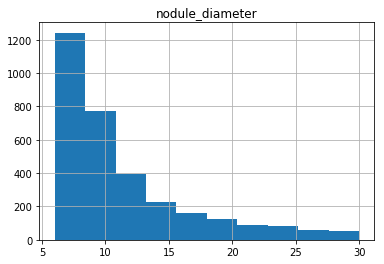

In [26]:
df_train.hist(column='nodule_diameter')
plt.show()

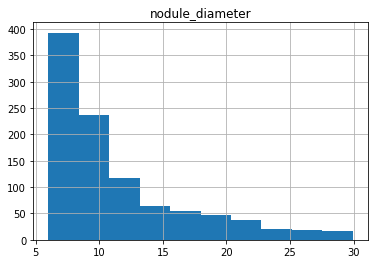

In [27]:
#look at  the distribution of nodules after filtering
df_valid.hist(column='nodule_diameter')
plt.show()

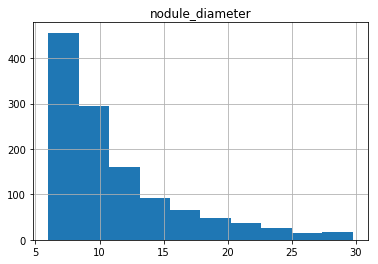

In [28]:
#look at  the distribution of nodules after filtering
df_test.hist(column='nodule_diameter')
plt.show()

The distribution of the nodule diameter is higly unbalanced. The number of small nodules is greater than the number of large nodules. Hence,  if uniform sampling is used, the network will be biased towards small nodules.

### Save train, validate, and test scan indices in a file

In [29]:
if True:
    scan_id_train=list(set(df_train["scan_id"]))
    scan_id_valid=list(set(df_valid["scan_id"]))
    scan_id_test=list(set(df_test["scan_id"]))
    filename = train_test_split_path
    with open(filename, 'wb') as f:
        pickle.dump([scan_id_train,scan_id_valid,scan_id_test], f)
else:
    filename=train_test_split_path
    with open(filename, 'rb') as f:
        scan_id_train,scan_id_valid,scan_id_test=pickle.load(f)

In [30]:
#scan_id_train,scan_id_valid,scan_id_test

In [31]:
scan_id_set = {ds_train: scan_id_train,
               ds_valid: scan_id_valid,
               ds_test: scan_id_test}

## Nodule Dataset 

#### Description

I will be taking small cubes from the ctscan volume. The size of this small cube is 52x52x52. I can serially decompose the say 512x512x300 ctscan volume into 52x52x52 cubes. But the problem with this approach is that I will have many "unintresting" cubes. like cubes that are all black. As an alternative, I will first create a lung mask. pick random points that resides inside the lung mask, and extract the 52x52x52 cube where the random point is the center of that cube. As a final check, I will make make sure that there does not exist a nodule in that cube, because remember we ar now generating negative examples. A summary of what I just described is:

1. get a scan
2. Apply the lung mask 
3. Find the range of zs where the lung occupies >2% of the total area. 
4. Select a random zc location.
5. On that z slice, apply the lung mask.
6. Select a random xc,yc point that resides inside the lung mask.
7. extract a cube where xc,yc,zc is its center and its side is N=52.
8. sum the mask of the newly generated cube to ensure that it does not include a nodule. 
9. The naming convention would be neg_scan_id_cx_xy_cz

#### Generate Negative Examples

In [32]:
ds_type = ds_train
interm_dir3 = tmp_path+ds_type+'/neg/'
interm_dir2 = tmp_path+ds_type+'/pos/'
fname_df = 'df_'+ds_type+'.csv'
epochs = 10

In [ ]:
random.seed(313)

In [60]:
for scan_id in scan_id_set[ds_type][xx+1:]:
    scan_1 = ctscan(scan_id) 
    S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

    T = B.shape[1]**2
    Areas=[np.sum(b)/T for b in B]
    ind2=[i for i,a in enumerate(Areas) if a>.02]
    z1,z2=ind2[0],ind2[-1]

    for k in range(epochs):
        zz=np.random.randint(z1,z2)

        Bf=B[zz].flatten()
        #In that slice, find the elements that are true
        Cs=[i for i,e in enumerate(Bf) if e]
        #randomly select an element from Cs
        i = random.choice(Cs)
        #from i get the original row and column of that element in B
        a=B.shape[1];a
        r = i//a
        c=i-a*r

        #Thus, we have succssfully selected a random point that resides inside the lung area
        #we would like to extract a 52x52x52 patch from the ctscan volume.
        #The patch is centered at the conditioned random point we have generated
        m = 52
        cz,cy,cx =[zz,r,c]
        #grap the volume
        image=scan_1.image_normalized #zxy
        cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
        cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)
        if np.sum(cube_label)==0:
            #save file
            filename=interm_dir3+'data_N_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
            with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([cube_img,cube_label.astype(np.bool)], f)
        else:
            k=k-1

#x=[i for i,j in enumerate(scan_id_train) if j==scan_id]
#xx=x[0]

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a 

In [59]:
x=[i for i,j in enumerate(scan_id_set[ds_type]) if j==scan_id]
xx=x[0]
xx#53,59,63,70,346,347,351,361,366,373,388

388

In [61]:
scan_id

1017

#### Read Negative Examples
it is handy to create a csv file that contains a list of the file names and its class and some other features

In [62]:
if True:
    temp=!ls {interm_dir3} -irlat #>> myfiles2.csv
    #keep string that satisfy a condition
    temp1=[t for t in temp if "data" in t]
    temp1[0:5]

    temp2=[t.split(" ")[-1] for t in temp1]

    df=pd.DataFrame([t.split(".")[0].split("_")[-4:] for t in temp2],columns=['scan_id','x','y','z'])

    df['label']=0
    df['filename']=temp2
    df.to_csv(tmp_path+ds_type+"df_neg_scanid_centroid.csv")
else:
    df=pd.read_csv(tmp_path+ds_type+"_df_neg_scanid_centroid.csv",index_col=0)
print(df.shape)
df.head(20)

(4391, 6)


,scan_id,x,y,z,label,filename
0,2,71,280,61,0,data_N_2_71_280_61.pkl
1,2,91,156,180,0,data_N_2_91_156_180.pkl
2,2,135,256,192,0,data_N_2_135_256_192.pkl
3,2,227,255,84,0,data_N_2_227_255_84.pkl
4,2,221,255,235,0,data_N_2_221_255_235.pkl
5,2,331,172,82,0,data_N_2_331_172_82.pkl
6,2,272,170,193,0,data_N_2_272_170_193.pkl
7,2,228,219,236,0,data_N_2_228_219_236.pkl
8,2,45,200,81,0,data_N_2_45_200_81.pkl
9,2,247,242,242,0,data_N_2_247_242_242.pkl


#### Generate Positive Examples

Our Strategy is to:
- pick a nodule at random (repition not allowed)
- extract the 52x52x52 cube
- The naming convention would be pos_scan_id_cx_xy_cz

In [86]:
m = 52
for scan_id in scan_id_set[ds_type][xx+1:]:
    #grap the volume
    scan_1 = ctscan(scan_id)
    image=scan_1.image_normalized #zxy
    for c2 in scan_1.centroids2:
        cx,cy,cz =c2
        cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
        cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)
        filename=interm_dir2+'data_P_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
        with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
            pickle.dump([cube_img,cube_label.astype(np.bool)], f)

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a 

In [87]:
x=[i for i,j in enumerate(scan_id_set[ds_type]) if j==scan_id]
xx=x[0]
xx#53,59,63,70,346,347,351,361,366,373,388

485

#### Read Positive Examples

In [88]:
if True:
    temp=!ls {interm_dir2} -irlat #>> myfiles2.csv
    #keep string that satisfy a condition
    temp1=[t for t in temp if "data" in t]
    temp1[0:5]

    temp2=[t.split(" ")[-1] for t in temp1]

    df=pd.DataFrame([t.split(".")[0].split("_")[-4:] for t in temp2],columns=['scan_id','x','y','z'])
    df['label']=1
    df['filename']=temp2
    #let us compute some analytics
    Area=[]
    for file in df.filename:
        filename=interm_dir2+'/'+file
        with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
            X,Y = pickle.load(f)
        Area.append(np.sum(Y)/52./52./52.*100)
    df["Area_percentage"] = Area
    
    df.to_csv(tmp_path+ds_type+"df_pos_scanid_centroid.csv")
else:
    df=pd.read_csv(tmp_path+ds_type+"df_pos_scanid_centroid.csv",index_col=0)
print(df.shape)
df.head(20)

(2629, 7)


,scan_id,x,y,z,label,filename,Area_percentage
0,2,91,275,164,1,data_P_2_91_275_164.pkl,10.036413
1,2,167,251,104,1,data_P_2_167_251_104.pkl,0.017780
2,2,124,272,80,1,data_P_2_124_272_80.pkl,3.216033
3,2,124,272,76,1,data_P_2_124_272_76.pkl,3.216033
4,2,91,276,166,1,data_P_2_91_276_166.pkl,10.036413
5,2,123,273,80,1,data_P_2_123_273_80.pkl,3.216033
6,2,91,274,164,1,data_P_2_91_274_164.pkl,10.036413
7,2,124,273,80,1,data_P_2_124_273_80.pkl,3.216033
8,5,68,276,144,1,data_P_5_68_276_144.pkl,0.492860
9,5,69,276,144,1,data_P_5_69_276_144.pkl,0.492860


Let us double check

In [89]:
filename=interm_dir2+'/'+df.filename[0]
print(filename)
with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
    X,Y = pickle.load(f)

/home/mas/x110/Datasets/Dataset5/tmp/train/pos//data_P_2_91_275_164.pkl


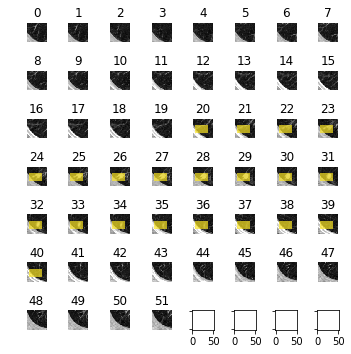

In [90]:
zs=52

X2 = X.copy()
Z2=Y.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=7
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(5,5))

ind=np.arange(0,52)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title(str(ii))
      
plt.tight_layout()

#### Combine both into a distribution of n:m (pos:neg)

In [91]:
dfp=pd.read_csv(tmp_path+ds_type+"df_pos_scanid_centroid.csv",index_col=0)
del dfp["Area_percentage"]
dfp.head()

,scan_id,x,y,z,label,filename
0,2,91,275,164,1,data_P_2_91_275_164.pkl
1,2,167,251,104,1,data_P_2_167_251_104.pkl
2,2,124,272,80,1,data_P_2_124_272_80.pkl
3,2,124,272,76,1,data_P_2_124_272_76.pkl
4,2,91,276,166,1,data_P_2_91_276_166.pkl


In [92]:
dfn=pd.read_csv(tmp_path+ds_type+"df_neg_scanid_centroid.csv",index_col=0)
dfn.head()

,scan_id,x,y,z,label,filename
0,2,71,280,61,0,data_N_2_71_280_61.pkl
1,2,91,156,180,0,data_N_2_91_156_180.pkl
2,2,135,256,192,0,data_N_2_135_256_192.pkl
3,2,227,255,84,0,data_N_2_227_255_84.pkl
4,2,221,255,235,0,data_N_2_221_255_235.pkl


In [93]:
dfp.shape[0],dfn.shape[0]

(2629, 4391)

In [94]:
n=np.int(dfp.shape[0]*.2)
n

525

In [95]:
df2= dfn.sample(n=n,random_state=313).reset_index(drop=True)
print(dfn.shape)
print(df2.shape)
df2.head()

(4391, 6)
(525, 6)


,scan_id,x,y,z,label,filename
0,139,132,280,156,0,data_N_139_132_280_156.pkl
1,578,206,229,124,0,data_N_578_206_229_124.pkl
2,404,170,190,170,0,data_N_404_170_190_170.pkl
3,396,96,143,101,0,data_N_396_96_143_101.pkl
4,65,126,286,120,0,data_N_65_126_286_120.pkl


In [96]:
df=dfp.append(df2)

In [97]:
df= df.sample(frac=1,random_state=313).reset_index(drop=True)
print(df.shape)
df.head()

(3154, 6)


,scan_id,x,y,z,label,filename
0,383,74,206,276,1,data_P_383_74_206_276.pkl
1,786,113,168,104,1,data_P_786_113_168_104.pkl
2,631,67,144,185,1,data_P_631_67_144_185.pkl
3,969,266,188,176,1,data_P_969_266_188_176.pkl
4,639,232,228,169,1,data_P_639_232_228_169.pkl


In [98]:
df.to_csv(processed_path+fname_df)

#### Data Augmentation

When I generated positive examples, I extracted the mini cube around the nodule. Hence, the nodule will always be at the center. Now, we need to change this by introducing some offset in all directions x,y,z.

The strategy is to get a random portion of this mini cube with the condition that the center should belong to the new "mini mini cube". The center of the original cube must contain a nodule (by design). Hence, this way we gurantee than the new cube will contain a nodule. 

By visually looking at the different scenarios of extracting a 32x32x32 cube from a 52x52x52 cube, I can say that all will contain the center.


In [99]:
random.seed(313)
def random_crop(img,label):
    #compute the upper left corner of the new cube
    x = random.randint(0, 20) #Assume input is 52x52x52
    y = random.randint(0, 20) #Assume input is 52x52x52
    z = random.randint(0, 20) #Assume input is 52x52x52
    img2 = img[x:x+32,y:y+32,z:z+32]
    label2 = label[x:x+32,y:y+32,z:z+32]

    return img2,label2

In [100]:
if False:
    filename=interm_dir2+df.filename[0]
    print(filename)
    with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
        X,Y = pickle.load(f)

    zs=32

    X2,Z2 = random_crop(X,Y)
    Z2 = np.ma.masked_where(Z2 ==0 , Z2)

    num_rows=6
    num_cols=6

    f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(5,5))

    ind=np.arange(0,32)
    for i in range(zs):
        ii=ind[i]
        plots[i // num_cols, i % num_cols].axis('off')
        plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

        plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
        plots[i // num_cols, i % num_cols].set_title(str(ii))

    plt.tight_layout()

#### Convert into rec file

In [101]:
import datetime 

now = datetime.datetime.now()
today = now.strftime('%Y-%m-%d')

In [102]:
today = today.replace('-','_')

In [103]:
import mxnet as mx #pip install mxnet-cu80
#write to .rec file
if False:#No longer used
    fname==processed_path+ds_type+today+'.rec'

    record = mx.recordio.MXRecordIO(fname, 'w')

    counter=0
    sum_img=np.zeros((32,32,32))


    for index, row in df.iterrows():
        if row['label']==1:
            path=interm_dir2
        else:
            path=interm_dir3

        filename=path+'/'+row.filename

        with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
            x,t=pickle.load(f)
            x,t = random_crop(x,t)



        sum_img+=x

        t=1*t.flatten()#(255*t.flatten()).astype(np.uint8)
        x=x.flatten()#(255*x.flatten()).astype(np.uint8)
        header = mx.recordio.IRHeader(flag=0, label=x, id=int(counter), id2=0)
        s = mx.recordio.pack_img(header, t, quality=100,img_fmt='.png')
        record.write(s)
        counter +=1
    record.close()

With the above method, I can read data sequentially. However, I need to create a .rec file that supports random access. 

In [104]:
import mxnet as mx #pip install mxnet-cu80
#write to .rec file
if True:    
    fname=processed_path+ds_type+today+'.rec'
    idx=processed_path+ds_type+today+'.idx'

    record = mx.recordio.MXIndexedRecordIO(idx, fname, 'w')

    counter=0
    sum_img=np.zeros((32,32,32))


    for index, row in df.iterrows():
        if row['label']==1:
            path=interm_dir2
        else:
            path=interm_dir3

        filename=path+'/'+row.filename

        with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
            x,t=pickle.load(f)
            x,t = random_crop(x,t)



        sum_img+=x

        t=1*t.flatten()#(255*t.flatten()).astype(np.uint8)
        x=x.flatten()#(255*x.flatten()).astype(np.uint8)
        header = mx.recordio.IRHeader(flag=0, label=x, id=int(counter), id2=0)
        s = mx.recordio.pack_img(header, t, quality=100,img_fmt='.png')
        record.write_idx(counter,s)
        counter +=1
    record.close()

#### Repeat for validate

In [122]:
ds_type = ds_valid
interm_dir3 = tmp_path+ds_type+'/neg/'
interm_dir2 = tmp_path+ds_type+'/pos/'
fname_df = 'df_'+ds_type+'.csv'

In [123]:
random.seed(313)


In [141]:
for scan_id in scan_id_set[ds_type][xx+1:]:
    scan_1 = ctscan(scan_id) 
    S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

    T = B.shape[1]**2
    Areas=[np.sum(b)/T for b in B]
    ind2=[i for i,a in enumerate(Areas) if a>.02]
    z1,z2=ind2[0],ind2[-1]

    for k in range(10):
        zz=np.random.randint(z1,z2)

        Bf=B[zz].flatten()
        #In that slice, find the elements that are true
        Cs=[i for i,e in enumerate(Bf) if e]
        #randomly select an element from Cs
        i = random.choice(Cs)
        #from i get the original row and column of that element in B
        a=B.shape[1];a
        r = i//a
        c=i-a*r

        #Thus, we have succssfully selected a random point that resides inside the lung area
        #we would like to extract a 52x52x52 patch from the ctscan volume.
        #The patch is centered at the conditioned random point we have generated
        m = 52
        cz,cy,cx =[zz,r,c]
        #grap the volume
        image=scan_1.image_normalized #zxy
        cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
        cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)
        if np.sum(cube_label)==0:
            #save file
            filename=interm_dir3+'data_N_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
            with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([cube_img,cube_label.astype(np.bool)], f)
        else:
            k=k-1

#x=[i for i,j in enumerate(scan_id_train) if j==scan_id]
#xx=x[0]

In [142]:
x=[i for i,j in enumerate(scan_id_set[ds_type]) if j==scan_id]
xx=x[0]
xx#77,80,84,88

161

In [143]:
len(scan_id_set[ds_type])

162

In [130]:
scan_id

757

In [144]:
if True:
    temp=!ls {interm_dir3} -irlat #>> myfiles2.csv
    #keep string that satisfy a condition
    temp1=[t for t in temp if "data" in t]
    temp1[0:5]

    temp2=[t.split(" ")[-1] for t in temp1]

    df=pd.DataFrame([t.split(".")[0].split("_")[-4:] for t in temp2],columns=['scan_id','x','y','z'])

    df['label']=0
    df['filename']=temp2
    df.to_csv(tmp_path+ds_type+"df_neg_scanid_centroid.csv")
else:
    df=pd.read_csv(tmp_path+ds_type+"_df_neg_scanid_centroid.csv",index_col=0)
print(df.shape)
df.head(20)

(2877, 6)


,scan_id,x,y,z,label,filename
0,513,243,163,202,0,data_N_513_243_163_202.pkl
1,513,94,221,202,0,data_N_513_94_221_202.pkl
2,513,67,234,218,0,data_N_513_67_234_218.pkl
3,513,281,119,78,0,data_N_513_281_119_78.pkl
4,513,235,169,202,0,data_N_513_235_169_202.pkl
5,513,97,256,249,0,data_N_513_97_256_249.pkl
6,513,70,154,141,0,data_N_513_70_154_141.pkl
7,513,250,135,127,0,data_N_513_250_135_127.pkl
8,521,267,215,301,0,data_N_521_267_215_301.pkl
9,521,135,229,76,0,data_N_521_135_229_76.pkl


In [153]:
m = 52
for scan_id in scan_id_set[ds_type][xx+1:]:
    #grap the volume
    scan_1 = ctscan(scan_id)
    image=scan_1.image_normalized #zxy
    for c2 in scan_1.centroids2:
        cx,cy,cz =c2
        cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
        cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)
        filename=interm_dir2+'data_P_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
        with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
            pickle.dump([cube_img,cube_label.astype(np.bool)], f)



Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a 

/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a 

In [154]:
x=[i for i,j in enumerate(scan_id_set[ds_type]) if j==scan_id]
xx=x[0]
xx#77,80,84,88

161

In [162]:
if True:
    temp=!ls {interm_dir2} -irlat #>> myfiles2.csv
    #keep string that satisfy a condition
    temp1=[t for t in temp if "data" in t]
    temp1[0:5]

    temp2=[t.split(" ")[-1] for t in temp1]

    df=pd.DataFrame([t.split(".")[0].split("_")[-4:] for t in temp2],columns=['scan_id','x','y','z'])
    df['label']=1
    df['filename']=temp2
    #let us compute some analytics
    Area=[]
    for file in df.filename:
        filename=interm_dir2+'/'+file
        with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
            X,Y = pickle.load(f)
        Area.append(np.sum(Y)/52./52./52.*100)
    df["Area_percentage"] = Area
    
    df.to_csv(tmp_path+ds_type+"df_pos_scanid_centroid.csv")
else:
    df=pd.read_csv(tmp_path+ds_type+"df_pos_scanid_centroid.csv",index_col=0)
print(df.shape)
df.head(20)

dfp=pd.read_csv(tmp_path+ds_type+"df_pos_scanid_centroid.csv",index_col=0)
del dfp["Area_percentage"]
dfp.head()

dfn=pd.read_csv(tmp_path+ds_type+"df_neg_scanid_centroid.csv",index_col=0)
dfn.head()

df2= dfn.sample(frac=.08,random_state=313).reset_index(drop=True)
print(dfn.shape)
print(df2.shape)
df2.head()

df=dfp.append(df2)

df= df.sample(frac=1,random_state=313).reset_index(drop=True)
print(df.shape)
df.head()

df.to_csv(processed_path+fname_df)

now = datetime.datetime.now()
today = now.strftime('%Y-%m-%d')

today = today.replace('-','_')

#write to .rec file
if True:    
    fname=processed_path+ds_type+today+'.rec'
    idx=processed_path+ds_type+today+'.idx'

    record = mx.recordio.MXIndexedRecordIO(idx, fname, 'w')

    counter=0
    sum_img=np.zeros((32,32,32))


    for index, row in df.iterrows():
        if row['label']==1:
            path=interm_dir2
        else:
            path=interm_dir3

        filename=path+'/'+row.filename

        with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
            x,t=pickle.load(f)
            x,t = random_crop(x,t)


        if x.shape==(32,32,32):

            sum_img+=x

            t=1*t.flatten()#(255*t.flatten()).astype(np.uint8)
            x=x.flatten()#(255*x.flatten()).astype(np.uint8)
            header = mx.recordio.IRHeader(flag=0, label=x, id=int(counter), id2=0)
            s = mx.recordio.pack_img(header, t, quality=100,img_fmt='.png')
            record.write_idx(counter,s)
            counter +=1
    record.close()

(883, 7)
(2877, 6)
(230, 6)
(1113, 6)


#### Repeat for test

In [164]:
ds_type = ds_test
interm_dir3 = tmp_path+ds_type+'/neg/'
interm_dir2 = tmp_path+ds_type+'/pos/'
fname_df = 'df_'+ds_type+'.csv'

In [165]:
random.seed(313)

In [175]:
for scan_id in scan_id_set[ds_type][xx+1:]:
    scan_1 = ctscan(scan_id) 
    S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

    T = B.shape[1]**2
    Areas=[np.sum(b)/T for b in B]
    ind2=[i for i,a in enumerate(Areas) if a>.02]
    z1,z2=ind2[0],ind2[-1]

    for k in range(10):
        zz=np.random.randint(z1,z2)

        Bf=B[zz].flatten()
        #In that slice, find the elements that are true
        Cs=[i for i,e in enumerate(Bf) if e]
        #randomly select an element from Cs
        i = random.choice(Cs)
        #from i get the original row and column of that element in B
        a=B.shape[1];a
        r = i//a
        c=i-a*r

        #Thus, we have succssfully selected a random point that resides inside the lung area
        #we would like to extract a 52x52x52 patch from the ctscan volume.
        #The patch is centered at the conditioned random point we have generated
        m = 52
        cz,cy,cx =[zz,r,c]
        #grap the volume
        image=scan_1.image_normalized #zxy
        cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
        cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)
        if np.sum(cube_label)==0:
            #save file
            filename=interm_dir3+'data_N_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
            with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([cube_img,cube_label.astype(np.bool)], f)
        else:
            k=k-1

#x=[i for i,j in enumerate(scan_id_train) if j==scan_id]
#xx=x[0]

In [176]:
x=[i for i,j in enumerate(scan_id_set[ds_type]) if j==scan_id]
xx=x[0]
xx#40,45,165

165

In [177]:
if True:
    temp=!ls {interm_dir3} -irlat #>> myfiles2.csv
    #keep string that satisfy a condition
    temp1=[t for t in temp if "data" in t]
    temp1[0:5]

    temp2=[t.split(" ")[-1] for t in temp1]

    df=pd.DataFrame([t.split(".")[0].split("_")[-4:] for t in temp2],columns=['scan_id','x','y','z'])

    df['label']=0
    df['filename']=temp2
    df.to_csv(tmp_path+ds_type+"df_neg_scanid_centroid.csv")
else:
    df=pd.read_csv(tmp_path+ds_type+"_df_neg_scanid_centroid.csv",index_col=0)
print(df.shape)
df.head(20)

(1849, 6)


,scan_id,x,y,z,label,filename
0,1,271,212,109,0,data_N_1_271_212_109.pkl
1,1,111,112,74,0,data_N_1_111_112_74.pkl
2,1,87,212,174,0,data_N_1_87_212_174.pkl
3,1,149,295,205,0,data_N_1_149_295_205.pkl
4,1,98,92,89,0,data_N_1_98_92_89.pkl
5,1,273,225,46,0,data_N_1_273_225_46.pkl
6,1,98,87,214,0,data_N_1_98_87_214.pkl
7,1,223,222,202,0,data_N_1_223_222_202.pkl
8,1,254,278,259,0,data_N_1_254_278_259.pkl
9,3,142,245,71,0,data_N_3_142_245_71.pkl


In [182]:
m = 52
for scan_id in scan_id_set[ds_type][xx+1:]:
    #grap the volume
    scan_1 = ctscan(scan_id)
    image=scan_1.image_normalized #zxy
    for c2 in scan_1.centroids2:
        cx,cy,cz =c2
        cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
        cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)
        filename=interm_dir2+'data_P_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
        with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
            pickle.dump([cube_img,cube_label.astype(np.bool)], f)


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a 

In [183]:
x=[i for i,j in enumerate(scan_id_set[ds_type]) if j==scan_id]
xx=x[0]
xx#40, 45, 

165

In [184]:
if True:
    temp=!ls {interm_dir2} -irlat #>> myfiles2.csv
    #keep string that satisfy a condition
    temp1=[t for t in temp if "data" in t]
    temp1[0:5]

    temp2=[t.split(" ")[-1] for t in temp1]

    df=pd.DataFrame([t.split(".")[0].split("_")[-4:] for t in temp2],columns=['scan_id','x','y','z'])
    df['label']=1
    df['filename']=temp2
    #let us compute some analytics
    Area=[]
    for file in df.filename:
        filename=interm_dir2+'/'+file
        with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
            X,Y = pickle.load(f)
        Area.append(np.sum(Y)/52./52./52.*100)
    df["Area_percentage"] = Area
    
    df.to_csv(tmp_path+ds_type+"df_pos_scanid_centroid.csv")
else:
    df=pd.read_csv(tmp_path+ds_type+"df_pos_scanid_centroid.csv",index_col=0)
print(df.shape)
df.head(20)

dfp=pd.read_csv(tmp_path+ds_type+"df_pos_scanid_centroid.csv",index_col=0)
del dfp["Area_percentage"]
dfp.head()

dfn=pd.read_csv(tmp_path+ds_type+"df_neg_scanid_centroid.csv",index_col=0)
dfn.head()

df2= dfn.sample(frac=.08,random_state=313).reset_index(drop=True)
print(dfn.shape)
print(df2.shape)
df2.head()

df=dfp.append(df2)

df= df.sample(frac=1,random_state=313).reset_index(drop=True)
print(df.shape)
df.head()

df.to_csv(processed_path+fname_df)

now = datetime.datetime.now()
today = now.strftime('%Y-%m-%d')

today = today.replace('-','_')

#write to .rec file
if True:    
    fname=processed_path+ds_type+today+'.rec'
    idx=processed_path+ds_type+today+'.idx'

    record = mx.recordio.MXIndexedRecordIO(idx, fname, 'w')

    counter=0
    sum_img=np.zeros((32,32,32))


    for index, row in df.iterrows():
        if row['label']==1:
            path=interm_dir2
        else:
            path=interm_dir3

        filename=path+'/'+row.filename

        with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
            x,t=pickle.load(f)
            x,t = random_crop(x,t)



        sum_img+=x

        t=1*t.flatten()#(255*t.flatten()).astype(np.uint8)
        x=x.flatten()#(255*x.flatten()).astype(np.uint8)
        header = mx.recordio.IRHeader(flag=0, label=x, id=int(counter), id2=0)
        s = mx.recordio.pack_img(header, t, quality=100,img_fmt='.png')
        record.write_idx(counter,s)
        counter +=1
    record.close()

(1022, 7)
(1849, 6)
(148, 6)
(1170, 6)
